## 数据填充

### 对sku_sales数据进行填充

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
STORE_ID = 1
SKU_ID = 1
CHANNEL_ID = 1
SALES_DATA_PATH = './data/sku_sales.csv'

In [5]:
data_sales = pd.read_csv(SALES_DATA_PATH)
data_sales

,order_id,store_id,sku_id,order_time,quantity,channel
0,202108310100005,1,317,2021-08-31 00:00:05,1.0,2
1,202108310100023,1,317,2021-08-31 00:00:23,2.0,2
2,202204260100049,1,317,2022-04-26 00:00:49,2.0,2
3,202207040100048,1,317,2022-07-04 00:00:48,2.0,2
4,202207060100029,1,317,2022-07-06 00:00:29,1.0,2
...,...,...,...,...,...,...
16934240,202308260300510,3,652,2023-08-26 00:08:30,1.0,2
16934241,202308260500228,5,652,2023-08-26 00:03:48,1.0,2
16934242,202308261202716,12,652,2023-08-26 00:45:16,1.0,1
16934243,202308231201236,12,652,2023-08-23 00:20:36,1.0,1


In [21]:
# 满足条件的数据
data_sales_single = data_sales[(data_sales['store_id'] == STORE_ID) & (data_sales['sku_id'] == SKU_ID) & (data_sales['channel'] == CHANNEL_ID)].copy()
data_sales_single.drop(['store_id', 'sku_id', 'order_id', 'channel'], axis=1, inplace=True)
# 将日销量求和
data_sales_single['order_time'] = pd.to_datetime(data_sales_single['order_time']).dt.date
data_sales_single.rename(columns={'order_time': 'date'}, inplace=True)
data_sales_single = data_sales_single.groupby(['date']).sum().reset_index()
data_sales_single

,date,quantity
0,2022-06-17,1.0
1,2022-06-18,4.0
2,2022-06-19,1.0
3,2022-06-24,1.0
4,2022-06-26,1.0
...,...,...
176,2023-08-24,4.0
177,2023-08-26,3.0
178,2023-08-27,8.0
179,2023-08-28,2.0


In [22]:
# 查看填充日期后有多少缺失值
data_sales_single.set_index('date', inplace=True)
data_sales_single = data_sales_single.asfreq('D')
data_sales_single

,quantity
date,
2022-06-17,1.0
2022-06-18,4.0
2022-06-19,1.0
2022-06-20,NaN
2022-06-21,NaN
...,...
2023-08-26,3.0
2023-08-27,8.0
2023-08-28,2.0


In [23]:
data_sales_single.isnull().sum()

quantity    259
dtype: int64

In [24]:
# 填充缺失值：使用前一天的销量填充
data_sales_ffill = data_sales_single.fillna(method='ffill')
data_sales_ffill

C:\Users\Yipeng\AppData\Local\Temp\ipykernel_12020\3775012193.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_sales_ffill = data_sales_single.fillna(method='ffill')


,quantity
date,
2022-06-17,1.0
2022-06-18,4.0
2022-06-19,1.0
2022-06-20,1.0
2022-06-21,1.0
...,...
2023-08-26,3.0
2023-08-27,8.0
2023-08-28,2.0


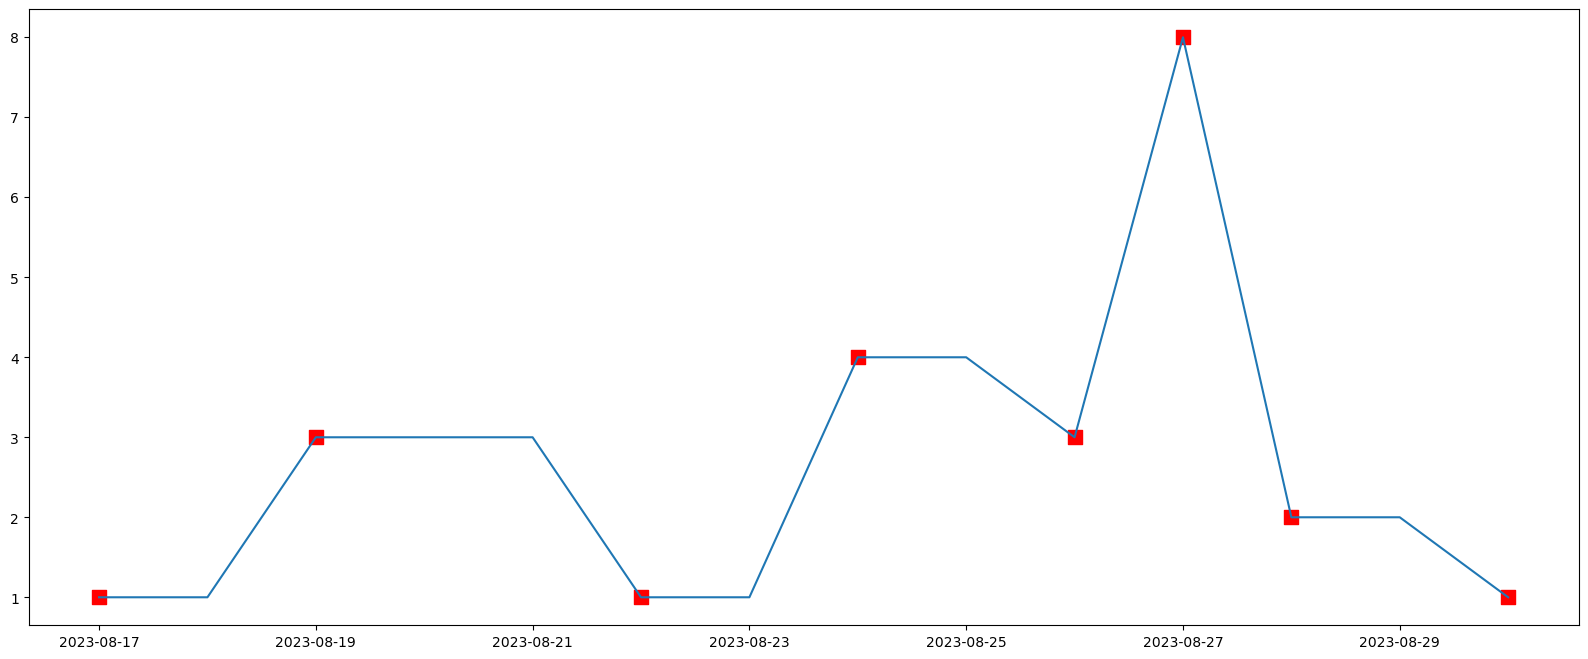

In [30]:
# 画图
plt.figure(figsize=(20, 8))
plt.plot(data_sales_ffill.index[-14:], data_sales_ffill['quantity'][-14:])
# 将data_sales中值为NAN的区域用长方形标记出来
plt.scatter(data_sales_single.index[-14:], data_sales_single['quantity'][-14:], marker='s', s=100, c='r')
plt.show()

In [31]:
# 填充缺失值：使用前一天的销量填充
data_sales_linear = data_sales_single.interpolate(method='linear')
data_sales_linear

,quantity
date,
2022-06-17,1.0
2022-06-18,4.0
2022-06-19,1.0
2022-06-20,1.0
2022-06-21,1.0
...,...
2023-08-26,3.0
2023-08-27,8.0
2023-08-28,2.0


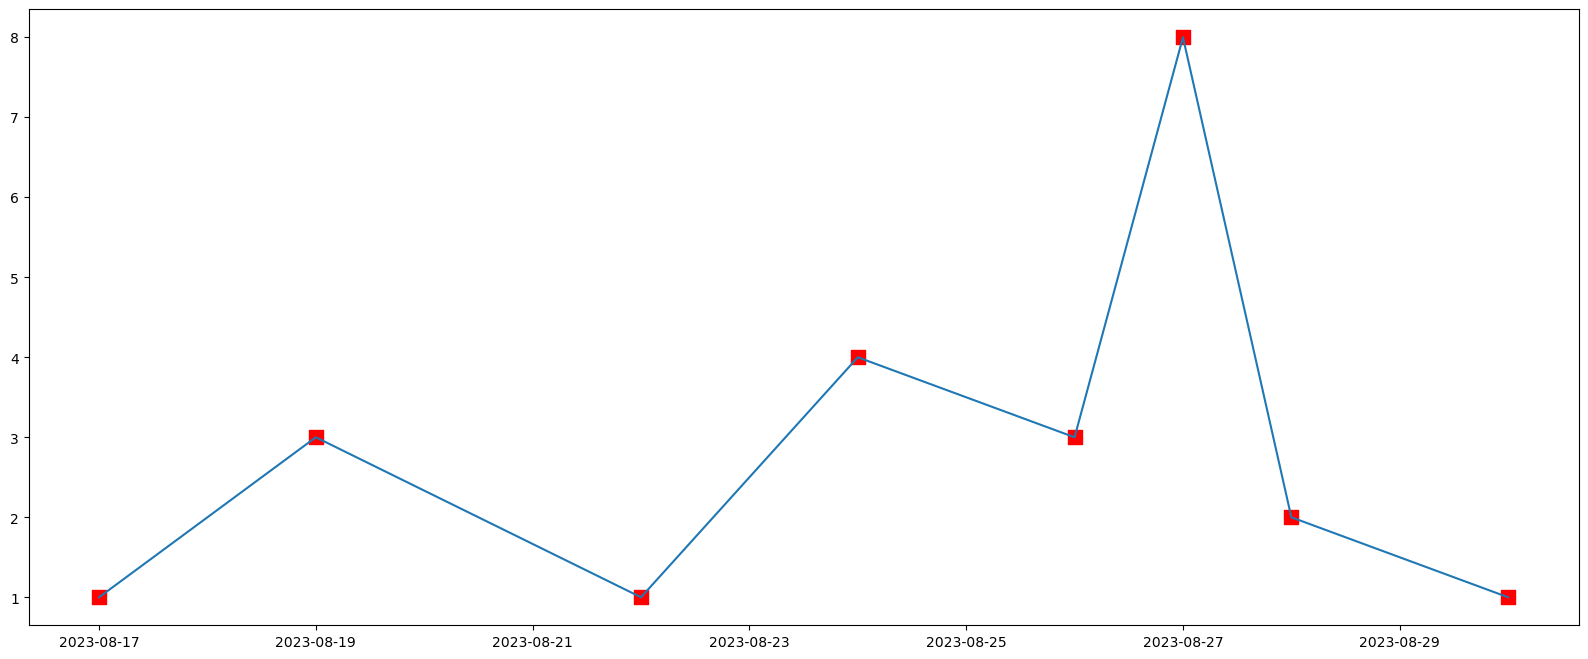

In [32]:
# 画图
plt.figure(figsize=(20, 8))
plt.plot(data_sales_linear.index[-14:], data_sales_linear['quantity'][-14:])
# 将data_sales中值为NAN的区域用长方形标记出来
plt.scatter(data_sales_single.index[-14:], data_sales_single['quantity'][-14:], marker='s', s=100, c='r')
plt.show()

In [76]:
def nmf(X, latent_features, max_iter=100, error_limit=1e-6, learning_rate=0.001, l2_penalty=0.001):
    """
    使用带L2正则化的NMF对有缺失值的矩阵X进行分解和填充。

    参数:
        X (np.ndarray): 原始数据矩阵，缺失值为np.nan
        latent_features (int): 隐含特征的数量
        max_iter (int): 最大迭代次数
        error_limit (float): 重构误差的阈值，达到则停止
        learning_rate (float): 梯度下降的学习率
        l2_penalty (float): L2正则化的权重

    返回:
        np.ndarray: 填充后的矩阵
    """

    # 初始化W和H为随机值
    W = np.abs(np.random.randn(X.shape[0], latent_features))
    H = np.abs(np.random.randn(latent_features, X.shape[1]))

    # 只在非缺失值上进行拟合
    mask = np.isfinite(X)
    X_safe = np.where(mask, X, 0)

    for epoch in range(max_iter):
        WH = np.dot(W, H)

        # 计算只针对非缺失值的重构误差
        cost = np.sum((mask * (X_safe - WH)) ** 2) + l2_penalty * (np.sum(W ** 2) + np.sum(H ** 2))

        if cost < error_limit:
            break

        if epoch % 10 == 0:
            print(f'Iteration {epoch}: cost={cost}')

        # 计算梯度
        grad_W = -2 * np.dot(mask * (X_safe - WH), H.T) + 2 * l2_penalty * W
        grad_H = -2 * np.dot(W.T, mask * (X_safe - WH)) + 2 * l2_penalty * H

        # 更新矩阵
        W -= learning_rate * grad_W
        H -= learning_rate * grad_H

        # 保持非负性
        W = np.maximum(W, 0)
        H = np.maximum(H, 0)

    return np.dot(W, H)

In [89]:
# 示例矩阵
X = data_sales_single['quantity'].values.reshape(1, -1)
# 应用NMF
latent_features = 2
X_filled = nmf(X, latent_features, max_iter=10000, learning_rate=0.01, error_limit=1e-6, l2_penalty=0)
data_sales_nmf = pd.DataFrame(X_filled.T, columns=['quantity'])
data_sales_nmf.index = data_sales_single.index
data_sales_nmf

Iteration 0: cost=338.1833903512862
Iteration 10: cost=25.27192206180559
Iteration 20: cost=2.5777917888377258
Iteration 30: cost=0.44368622228306787
Iteration 40: cost=0.09918630029663825
Iteration 50: cost=0.0250736533144404
Iteration 60: cost=0.00670247452833706
Iteration 70: cost=0.0018433578839593396
Iteration 80: cost=0.0005160265409311924
Iteration 90: cost=0.00014634847416497966
Iteration 100: cost=4.184396277744582e-05
Iteration 110: cost=1.2045623626420141e-05
Iteration 120: cost=3.4918769247320013e-06
Iteration 130: cost=1.0191905532319522e-06


,quantity
date,
2022-06-17,1.000009
2022-06-18,4.000009
2022-06-19,0.999991
2022-06-20,4.869278
2022-06-21,5.609435
...,...
2023-08-26,2.999996
2023-08-27,8.000010
2023-08-28,2.000004


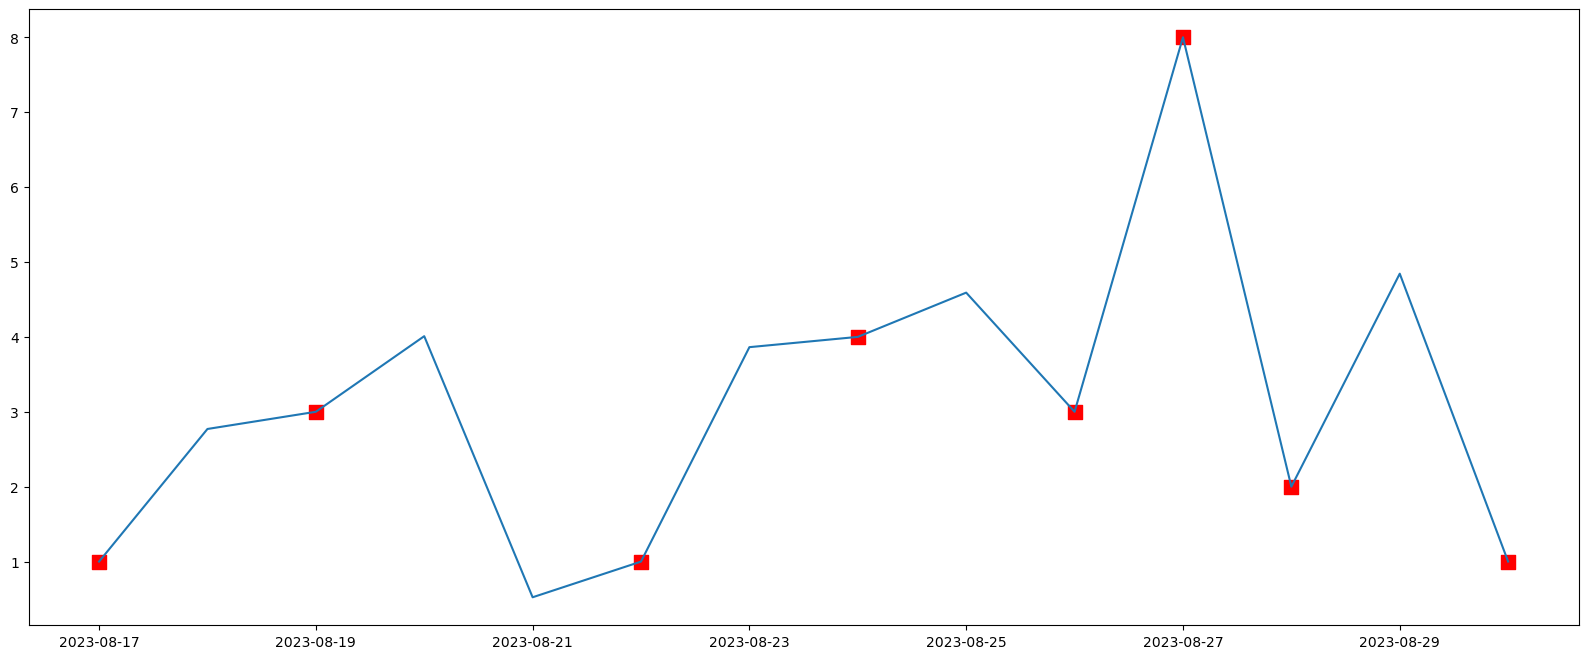

In [90]:
# 画图
plt.figure(figsize=(20, 8))
plt.plot(data_sales_nmf.index[-14:], data_sales_nmf['quantity'][-14:])
# 将data_sales中值为NAN的区域用长方形标记出来
plt.scatter(data_sales_single.index[-14:], data_sales_single['quantity'][-14:], marker='s', s=100, c='r')
plt.show()

In [109]:
# 尝试预测一下
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

def arima_forecast(time_series, steps, order=(1,1,1)):
    """
    使用ARIMA模型进行时间序列预测。

    参数:
        time_series (pd.Series): 时间序列数据
        steps (int): 需要预测的时间步数
        order (tuple): ARIMA模型的参数 (p, d, q)

    返回:
        np.ndarray: 预测的结果
    """

    # 检查时间序列的平稳性
    result = adfuller(time_series)
    if result[1] > 0.05:
        # 如果不平稳，进行差分直到数据平稳
        print('Time series is not stationary, applying differencing...')
        time_series_diff = time_series.diff().dropna()
    else:
        print('Time series is stationary, no differencing needed...')
        time_series_diff = time_series

    # model = auto_arima(time_series, seasonal=False, trace=True,
    #                 error_action='ignore', suppress_warnings=True,
    #                 stepwise=True)
    # p, d, q = model.order

    # 拟合ARIMA模型
    model = ARIMA(time_series, order=order)
    model_fit = model.fit()

    # 进行预测
    forecast = model_fit.forecast(steps=steps)

    return forecast


Time series is stationary, no differencing needed...
2023-08-18    2.518926
2023-08-19    2.587814
2023-08-20    2.590938
2023-08-21    2.591080
2023-08-22    2.591086
2023-08-23    2.591087
2023-08-24    2.591087
2023-08-25    2.591087
2023-08-26    2.591087
2023-08-27    2.591087
2023-08-28    2.591087
2023-08-29    2.591087
2023-08-30    2.591087
2023-08-31    2.591087
Freq: D, Name: predicted_mean, dtype: float64


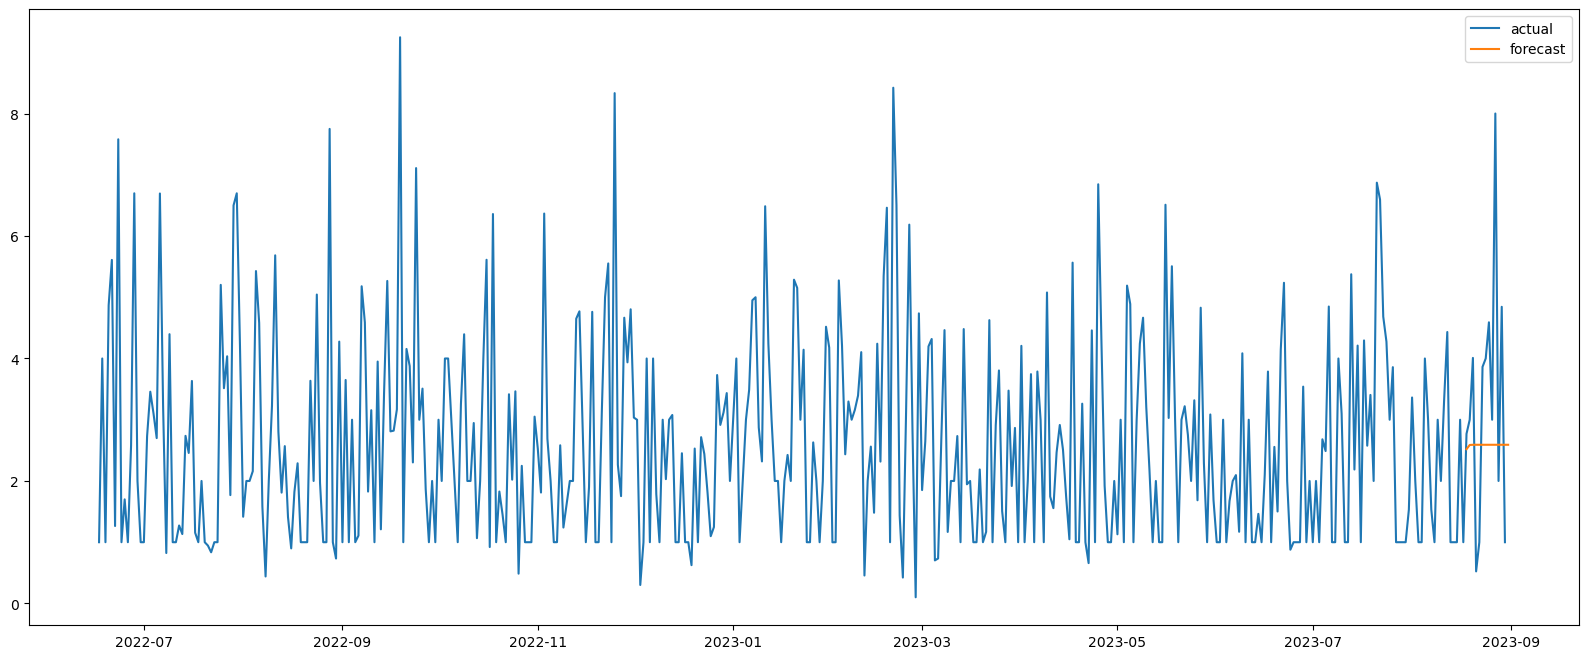

In [110]:
# 将data_sales_single转换为时间序列
data_sales_ts = data_sales_nmf['quantity']
data_sales_ts.index = pd.to_datetime(data_sales_ts.index)
# 将2023-08-16及之前的数据拿出来，预测未来14天的销量
data_sales_train = data_sales_ts[:'2023-08-17']
data_sales_test = data_sales_ts['2023-08-17':]

forecast = arima_forecast(data_sales_train, 14, (1, 1, 1))
print(forecast)

# 画图
plt.figure(figsize=(20, 8))
plt.plot(data_sales_ts.index, data_sales_ts.values, label='actual')
plt.plot(forecast.index, forecast.values, label='forecast')
plt.legend()
plt.show()

In [33]:
# 尝试查看销量为0的时候是否会出现缺失值
# 读取price and status的数据
data_prices = pd.read_csv('./data/sku_price_and_status.csv')
data_prices

,store_id,sku_id,date,salable_status,stock_status,original_price
0,6,1,2022-06-16,1,1,25.48
1,6,1,2023-04-08,1,1,25.48
2,6,1,2021-10-07,0,1,25.48
3,6,1,2021-12-25,0,1,25.48
4,6,1,2022-12-02,1,1,25.48
...,...,...,...,...,...,...
5104151,4,367,2023-08-17,1,1,17.28
5104152,4,367,2023-08-14,1,1,17.28
5104153,4,367,2023-08-15,1,1,17.28
5104154,4,367,2023-08-29,1,1,17.28


In [46]:
data_prices_single = data_prices[(data_prices['store_id'] == STORE_ID) & (data_prices['sku_id'] == SKU_ID)].copy()
data_prices_single.drop(['store_id', 'sku_id'], axis=1, inplace=True)
data_prices_single['date'] = pd.to_datetime(data_prices_single['date']).dt.date
data_prices_single.set_index('date', inplace=True)
data_prices_single.sort_index(inplace=True)
data_prices_single = data_prices_single.asfreq('D')
data_prices_single

,salable_status,stock_status,original_price
date,,,
2021-08-31,0,1,25.48
2021-09-01,0,1,25.48
2021-09-02,0,1,25.48
2021-09-03,0,1,25.48
2021-09-04,0,1,25.48
...,...,...,...
2023-09-10,-1,-1,22.38
2023-09-11,-1,-1,22.38
2023-09-12,-1,-1,22.38


In [47]:
# 将data_prices_single和data_sales_single合并
data_sales_prices = pd.merge(data_sales_single, data_prices_single, left_index=True, right_index=True)
data_sales_prices

,quantity,salable_status,stock_status,original_price
date,,,,
2022-06-17,1.0,1,1,25.48
2022-06-18,4.0,1,1,25.48
2022-06-19,1.0,1,1,25.48
2022-06-20,NaN,1,0,25.48
2022-06-21,NaN,1,0,25.48
...,...,...,...,...
2023-08-26,3.0,1,1,22.38
2023-08-27,8.0,1,1,22.38
2023-08-28,2.0,1,1,22.38


In [48]:
data_sales_prices[-14:]

,quantity,salable_status,stock_status,original_price
date,,,,
2023-08-17,1.0,1,1,22.38
2023-08-18,NaN,1,1,22.38
2023-08-19,3.0,1,1,22.38
2023-08-20,NaN,1,1,22.38
2023-08-21,NaN,1,1,22.38
2023-08-22,1.0,1,1,22.38
2023-08-23,NaN,1,1,22.38
2023-08-24,4.0,1,1,22.38
2023-08-25,NaN,1,1,22.38
